In [2]:
"""

"""


import pandas as pd
import matplotlib.pyplot as plt

import __init__

from db.pgdf import PgDf
from db.postgresql import PostgreSqlDB

d = PostgreSqlDB()
pg = PgDf()

df = pg.read_sql("""SELECT 
CASE WHEN t.result = 'lose' THEN -1
    WHEN t.result = 'win' THEN 1
    ELSE 0
END AS result,
t.profit/20000 as profit,
ABS(t.takeprofit_price - t.open_price)/ABS(t.stoploss_price - t.open_price) as ts_rate,
z.*
FROM zz_strtg_params as z
JOIN trades as t ON t.order_id = z.order_id
WHERE t.trade_name = 'zzstrat_top1000vol'
AND abs(t.profit) > 0
;""")



In [3]:
df.columns

Index(['result', 'profit', 'ts_rate', 'order_id', 'codename', 'side',
       'takeprofit_price', 'stoploss_price', 'ep', 'dt', 'price', 'trend',
       'vol_rank', 'trade_pos_key', 'tp_diff', 'prefer_recent_peaks',
       'peak_broken', 'mado', 'acc', 'trend_rate', 'chiko', 'len_std',
       'hara_rate', 'up_hige_rate', 'dw_hige_rate', 'len_avg', 'reversed_cnt',
       'momiai'],
      dtype='object')

In [4]:
print("total: %d" % len(df))
print("lose:  %d" % len(df[df.result == -1]))
print("profit total: %f" % df.profit.sum())

total: 1689
lose:  813
profit total: 26.600001


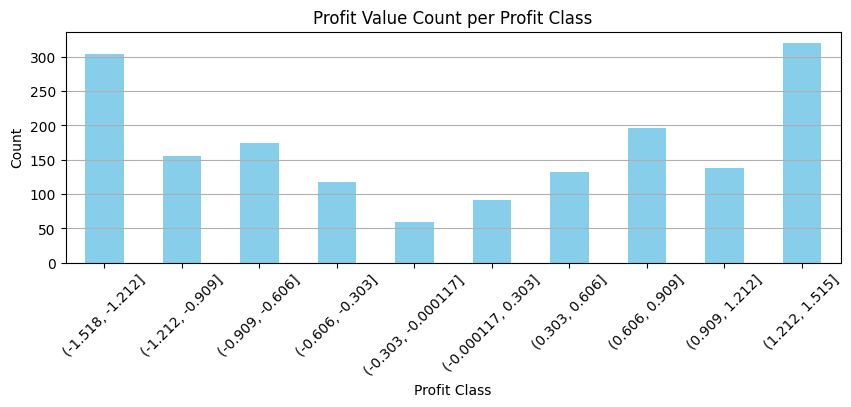

In [5]:
# Classify profit values into 10 classes
df['profit_class'] = pd.cut(df['profit'], bins=10)

# Count the profit values per class
profit_class_counts = df['profit_class'].value_counts().sort_index()

# Plot the result
plt.figure(figsize=(10, 3))
profit_class_counts.plot(kind='bar', color='skyblue')
plt.title('Profit Value Count per Profit Class')
plt.xlabel('Profit Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

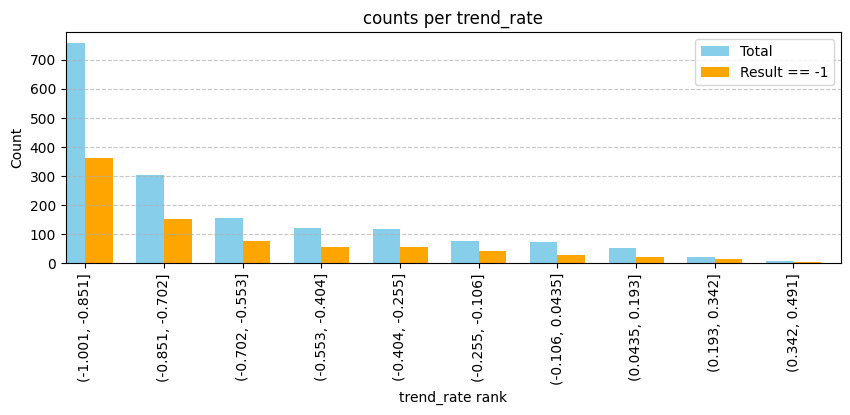

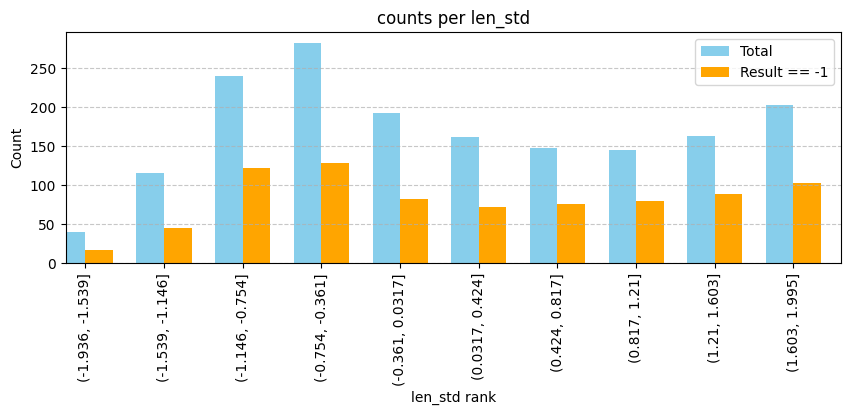

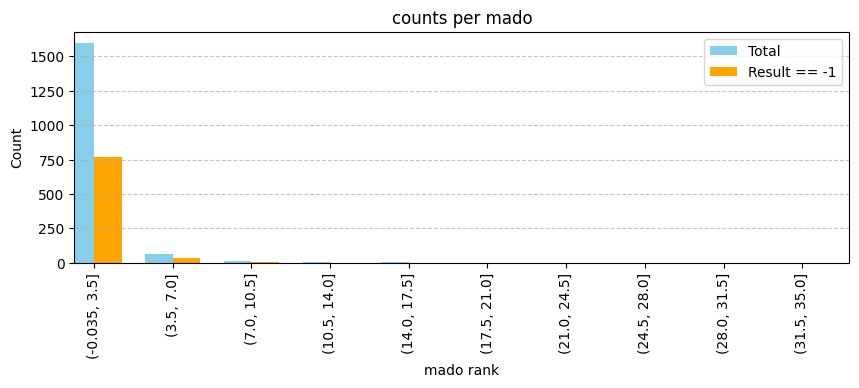

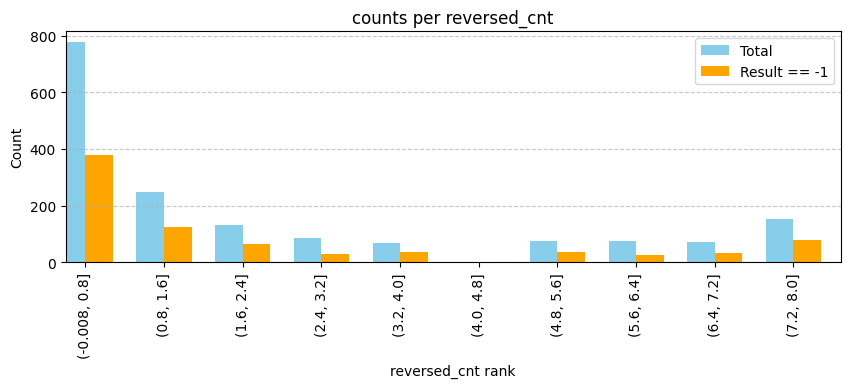

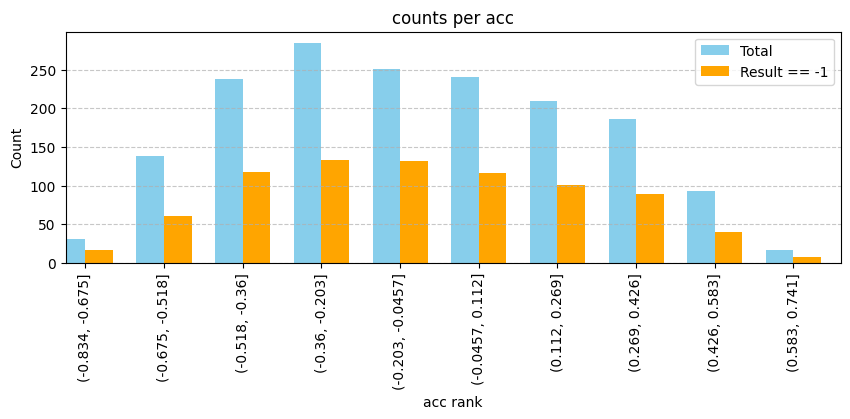

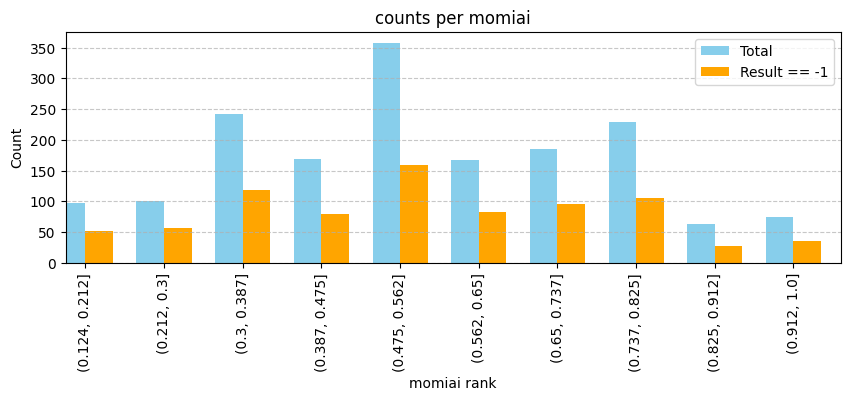

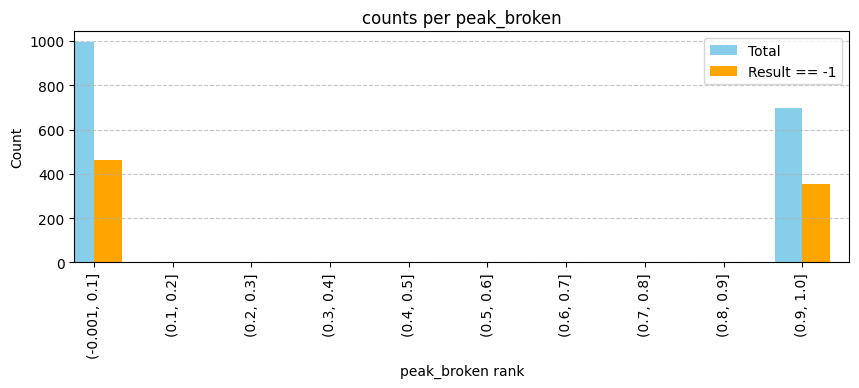

In [6]:
for item in ['trend_rate', 'len_std', 'mado', 'reversed_cnt', 'acc', 'momiai', 'peak_broken']:

    # Rank the trend_rate column
    #df['rank'] = df['trend_rate'].rank(method='min')
    df['rank'] = pd.cut(df[item], bins=10)
    
    # Count occurrences of each rank
    total_rank_counts = df['rank'].value_counts().sort_index()
    
    # Filter DataFrame where result == -1 and count occurrences of each rank
    df_filtered = df[df['result'] == -1]
    filtered_rank_counts = df_filtered['rank'].value_counts().sort_index()
    
    # Align both series to have the same index
    combined_counts = pd.concat([total_rank_counts, filtered_rank_counts], axis=1, keys=['Total', 'Result -1']).fillna(0)
    
    # Plot the graph
    fig, ax = plt.subplots(figsize=(10, 3))
    width = 0.35  # the width of the bars
    
    # Plotting the total counts
    combined_counts['Total'].plot(kind='bar', color='skyblue', width=width, position=1, label='Total', ax=ax)
    
    # Plotting the counts where result == -1
    combined_counts['Result -1'].plot(kind='bar', color='orange', width=width, position=0, label='Result == -1', ax=ax)
    
    plt.title('counts per %s' % item)
    plt.xlabel('%s rank' % item)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()

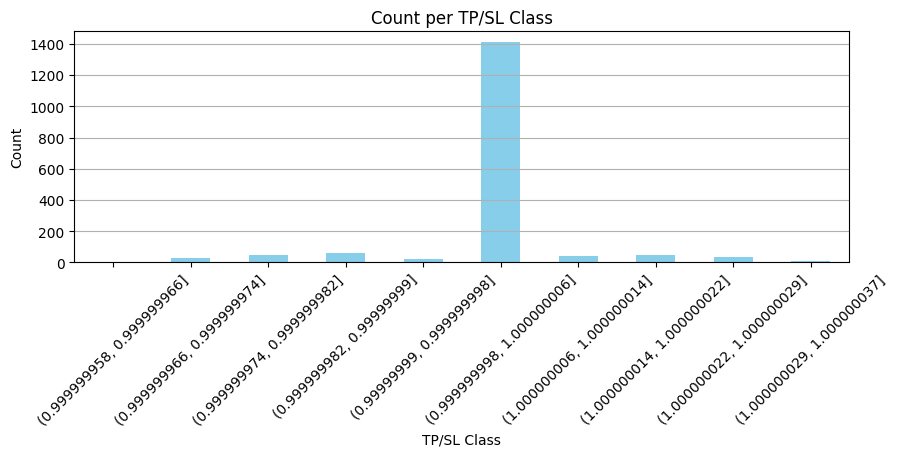

In [7]:
# Classify profit values into 10 classes
#df['profit_class'] = pd.cut(df['ts_rate'], bins=20)
df['profit_class'] = pd.cut(df['ts_rate'], bins=10)

# Count the profit values per class
profit_class_counts = df['profit_class'].value_counts().sort_index()

# Plot the result
plt.figure(figsize=(10, 3))
profit_class_counts.plot(kind='bar', color='skyblue')
plt.title('Count per TP/SL Class')
plt.xlabel('TP/SL Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [17]:
# win/lose per codenames

df = pg.read_sql("""WITH a AS (
    SELECT codename, count(*) as cnt FROM trades
    WHERE trade_name = 'zzstrat_top1000vol'
    GROUP BY 1
), b AS (
    SELECT codename, result, count(*) cnt, sum(profit) as profit FROM trades
    WHERE codename IN (SELECT codename FROM a WHERE a.cnt > 15)
    GROUP BY 1,2
), w AS (SELECT * FROM b WHERE result = 'win'),
l AS (SELECT * FROM b WHERE result = 'lose')

SELECT w.codename, w.cnt as win, l.cnt as lose, w.profit as wprofit, l.profit as lprofit, w.profit+l.profit as profit 
FROM w
LEFT JOIN l ON w.codename = l.codename
ORDER BY profit desc
;""")
df

,codename,win,lose,wprofit,lprofit,profit
0,3382.T,15,5,253265.068572,-100261.160617,153003.907955
1,8053.T,13,4,170368.907481,-36281.854691,134087.052790
2,6981.T,11,5,248590.183842,-114857.201611,133732.982231
3,4568.T,11,7,267169.971598,-140268.307571,126901.664027
4,7453.T,10,6,238413.923476,-137745.568217,100668.355259
5,7202.T,11,7,251860.696551,-159733.653652,92127.042899
6,6503.T,10,6,222063.187199,-138653.278616,83409.908583
7,6954.T,11,7,242195.781661,-163612.832753,78582.948908
8,8031.T,10,6,190993.711558,-116159.140454,74834.571104
9,6770.T,9,7,198109.597208,-123849.682408,74259.914800
